In [160]:
import pandas as pd
import numpy as np
import re
import preprocessor as p
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
# import data
train = pd.read_csv('data/Corona_NLP_train.csv', engine='python')
test = pd.read_csv('data/Corona_NLP_test.csv', engine='python')

In [3]:
# take a look
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [152]:
## function for cleaning tweets
stop_words = stopwords.words("english")
### for lemmatization
lemma = WordNetLemmatizer()
def cleanTwt(twt):
    # clean twt (e.g. url, mention, hashtags, reserved words, emoji, smiley, number)
    twt = p.clean(twt)
    # remove punctuations (e.g. ',.*!')
    twt = re.sub('[%s]' % re.escape(string.punctuation), ' ', twt)
    # convert to lower case
    twt = twt.lower()
    # lemmatization and remove stop words
    twt = ' '.join([lemma.lemmatize(word) for word in twt.split(' ') if word not in stop_words])
    # replace extra spaces
    twt = re.sub(r'\s{2,}',' ',twt)

    return twt

## function for encode sentiment as score
sentimentToscore={
    "Extremely Negative" : 0,
    "Negative" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Extremely Positive" : 4
}
def encodeSentiment(sentiment):
    return sentimentToscore[sentiment]
    
## examine sentiment distribution in train/test data
def plotSentimentDistribution(dataset,datasetLabel):
    sentimentDistPlt=dataset['SentimentScore'].value_counts(sort=False).sort_index().plot(kind='barh')
    sentimentDistPlt.set_xlabel("Number of tweets in %s dataset"%datasetLabel)
    sentimentDistPlt.set_ylabel("Sentiment")
    return sentimentDistPlt

## select columns of interest: CleanTweet & SentimentScore
def selectCol(dataset,cols):
    # replace empty string with NaN, and drop rows with NaN/duplicates
    dt = dataset[cols].replace(r'',np.nan).replace(r' ',np.nan).dropna().drop_duplicates()
    return dt

## input datasets and the column to prepare tweet from
def prepAllTwt(dataset1,dataset2,col):
    dt1 = selectCol(dataset1,col)
    dt2 = selectCol(dataset2,col)
    dt = dt1.append(dt2)
    return dt

In [5]:
train['CleanTweet'] = train.OriginalTweet.apply(cleanTwt)
train['SentimentScore'] = train.Sentiment.apply(encodeSentiment)
test['CleanTweet'] = test.OriginalTweet.apply(cleanTwt)
test['SentimentScore'] = test.Sentiment.apply(encodeSentiment)

In [143]:
# select CleanTweet & SentimentScore 
train_clean=selectCol(train,['CleanTweet','SentimentScore'])
test_clean=selectCol(test,['CleanTweet','SentimentScore'])

<AxesSubplot:xlabel='Number of tweets in training dataset', ylabel='Sentiment'>

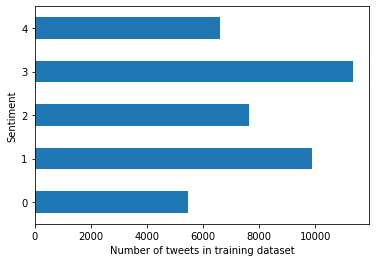

In [144]:
# examine sentiment distribution for train/test data (result: similar distribution; fewer tweets in extreme cases)
plotSentimentDistribution(train_clean,"training")

<AxesSubplot:xlabel='Number of tweets in testing dataset', ylabel='Sentiment'>

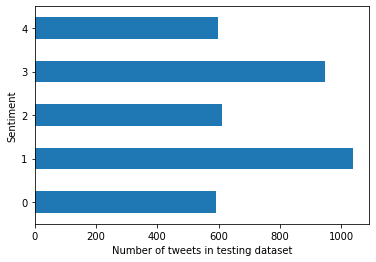

In [145]:
plotSentimentDistribution(test_clean,"testing")

### Tweet sentiment classification

In [92]:
y_train=train_clean.SentimentScore.tolist()
y_test=test_clean.SentimentScore.tolist()

#### Logistic regression

In [161]:
pipeline = Pipeline([
    ('vect',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('clf',LogisticRegression(solver='liblinear',multi_class='auto')),
])
logi_model = pipeline.fit(train_clean['CleanTweet'],train_clean['SentimentScore'])

In [162]:
# prediction
y_pred_logi = logi_model.predict(test_clean['CleanTweet'])
logi_model.report = classification_report(y_test,y_pred_logi)
print(logi_model.report)

              precision    recall  f1-score   support

           0       0.62      0.48      0.54       591
           1       0.52      0.48      0.50      1040
           2       0.60      0.67      0.63       610
           3       0.48      0.61      0.53       947
           4       0.69      0.54      0.61       598

    accuracy                           0.55      3786
   macro avg       0.58      0.56      0.56      3786
weighted avg       0.56      0.55      0.55      3786



### Tweet Clustering

In [163]:
all_clean = prepAllTwt(train,test,['CleanTweet'])
all_clean_twt = all_clean.CleanTweet.tolist()

In [164]:
tfv = TfidfVectorizer()
twt_tfv = tfv.fit_transform(all_clean_twt)

In [167]:
# find optimal k
sumOfsqrDist = []
K = range(2,12)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200,n_init=10)
    km = km.fit(twt_tfv)
    sumOfsqrDist.append(km.inertia_)

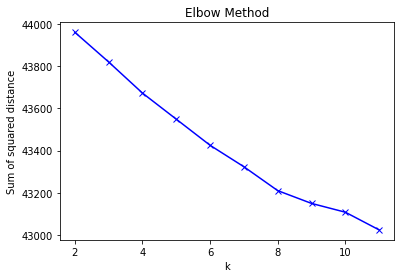

In [168]:
# use Elbow Method to find the optimal k
plt.plot(K, sumOfsqrDist,'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method')
plt.show()

In [169]:
# use k=8 to cluster tweets
set_k = 8
Kmean_model = KMeans(n_clusters=set_k, init='k-means++',max_iter=200,n_init=10)
Kmean_model.fit(twt_tfv)
Kmean_model_labels = Kmean_model.labels_
twt_cluster = pd.DataFrame(list(zip(all_clean_twt,Kmean_model_labels)),columns=['tweet','cluster'])

### Cluster interpretation

(determined from the top 20 tweets in each cluster)  
- cluster 0: things happened at supermarkets (e.g. employee, retail stock ...)
- cluster 1: online shopping
- cluster 2: economic/well-being impacts of covid19
- cluster 3: consumer/food/stock market/... price rising issue 
- cluster 4: toilet paper running out
- cluster 5: grocery shopping experience
- cluster 6: food stock issue 
- cluster 7: consumer behavior  

In [170]:
pd.set_option('display.max_colwidth', None)

In [171]:
cluster_0 = twt_cluster[twt_cluster['cluster']==0][['tweet']]
cluster_0.head(20)

,tweet
9,month crowding supermarket restaurant however reducing hour closing mall mean everyone using entrance dependent single supermarket
27,soon dwindling supply unlawful panicky people breaking closed store amp supermarket raid normally crisis massive amp lockup
34,yes buy need point posting photo people supermarket load stuff could buying elderly parent kid sibling etc buy themselvesnot everything need viral covid 19 alr
37,go supermarket like without judged
44,please share know someone living struggling get local supermarket due issue around offering free delivery healthy soup nationwide anyone need plus freezable
66,yeah parent risky people covid thats stay home go supermarket really necessary stay safe
78,check folk cal like idea la habra supermarket offer special hour senior amid covid 19 crisis
91,pretty sure within week two supermarket supply chain dry county effected covid 19 possibly go lockdown would government introduce form rationing people eat somehow think
92,supermarket worker frontline covid 19 extraordinary time retail extreme pressure shopping please remain calm thank worker everything keep shelf stocked checkout moving
94,biggest supermarket chain united state employee many receive sick leave even employee tested positive covid 19 still provide paid sick leave everyone


In [172]:
cluster_1 = twt_cluster[twt_cluster['cluster']==1][['tweet']]
cluster_1.head(20)

,tweet
0,advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order
1,coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak
7,due covid 19 retail store classroom atlanta open walk business class next two week beginning monday march continue process online phone order normal thank understanding
8,corona prevention stop buy thing cash use online payment method corona spread note also prefer online shopping home time fight covid
11,caring community let look le capable village ensure stay healthy bringing shopping door help online shopping self isolation symptom exposed somebody
16,amazon glitch stymy whole food fresh grocery deliveriesas covid 19 spread weve seen significant increase people shopping online grocery spokeswoman said statement today resulted system impact affecting
38,provide safe shopping experience customer healthy environment associate community online order placed
39,curious think retail shopper lot online shopping bc home unable go think everyone spooked get extra pair shoe
41,breaking story online clothes shopping rise people find mysterious white patch forming clothes
51,dear coronavirus following social distancing rule staying home prevent spread however spent alarming amount money shopping online submit expense reimbursement let know


In [173]:
cluster_2 = twt_cluster[twt_cluster['cluster']==2][['tweet']]
cluster_2.head(20)

,tweet
18,nation inficted covid world must play fair china goverments must demand china adopts new guilde line food safty chinese goverment guilty irosponcible life global scale
20,amazing cheap deal going help resonable dm u
21,amazing cheap deal going help resonable dm u iptvlinks
25,morning tested positive covid feel ok symptom far isolated since found possible exposure virus stay home people pragmatic keep updated im panic
32,sorry say event cancelled due covid 19 health wellbeing attendee speaker staff top priority apology disappointment may cause faq answered link
36,wife work retail amp customer came yesterday coughing everywhere saying covid 19 requested deep clean store company objected due cost recommending team spray disinfectant amp clean gonna die get sick due capitalism
46,never thought say come back please
47,covid 19 restriction sparking run cannabis storesthey closed yet customer stocking cannabis weekend preparing could retail store restriction coming day
53,morning everyone great safe day
71,pausing student loan payment addition halting interest accumulation amp stopping punitive student loan collection would provide much needed immediate relief individual unable work amp facing economic hardship


In [174]:
cluster_3 = twt_cluster[twt_cluster['cluster']==3][['tweet']]
cluster_3.head(20)

,tweet
52,global food price spread covid intensified across several geography could see downward pressure coming month due continued well supplied market negative impact demand resulting virus
64,seen facebook group business need stop increasing price essential emergency situation frankly despicable totally void community spirit 19uk
70,corona scare sends sea food price skyrocketing mumbai gt gt
76,disgusting disgraceful charging inflated price item stopping spread covid 19 government really need something abou
114,fringing idiot like caused price rise amp create shortage also probably wasted lot money expiry date shopkeeper must use rationing fair customer
117,poor customer service let algorithm run price state emergency refund cost also poor staffing
132,office ready prosecute price gouger deal texan need file complaint call 621 0508 online
182,stock market correctionscurrency rate correctionsoil price correctionsinterest rate changescurrency rate fluctuation lifestyle correctionwisdom collectivenessrespect nature reciprocateno one
229,watson f10 selling mask high price providing bill receipt
260,due fear people started hoarding item daily use impact regular level supply market commodity disappear market create shortage price go people start cursing government


In [175]:
cluster_4 = twt_cluster[twt_cluster['cluster']==4][['tweet']]
cluster_4.head(20)

,tweet
4,news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good report
6,supermarket today buy toilet paper
33,went supermarket yesterday toilet paper gone anything corona virus
54,thing panic buy emergency get toilet paper important afraid worst case scenario wash tub use money food crazy
65,sadly misinformed thinking covid 19 give diarrhoea therefore stock pile toilet paper atm hygiene food important
97,took picture today home grocery store montgomery county md flour sugar sweet potato potato orange juice paper towel toilet paper low meat mac amp cheese
125,katie moving weekend amongst covid panic yes food toilet paper self respect also least
163,actual footage trying go grocery store weekend im sure yall toilet paper please remember together
168,mass hysteria isnt going successfully deal covid 19 majority contracting covid 19 see mild flu symptom need panic buy month worth toilet paper canned food
169,went store today canned food gone needed toilet paper actually got pack roll got milk cat treat well thank god save food still stuff case covid 19 province panic buying common


In [176]:
cluster_5 = twt_cluster[twt_cluster['cluster']==5][['tweet']]
cluster_5.head(20)

,tweet
5,cashier grocery store sharing insight prove credibility commented civics class know talking
14,line grocery store unpredictable eating safe alternative find whether avoiding restaurant right
29,hole food image nicest grocery store one richest neighborhood united state 19
30,retail store closure could explode via
31,coronavirus fun fact cough grocery store get whole aisle pretty quickly
42,line outside customer wait store open morning
45,people posting sharing photo half completely empty shelf calling people dumb idiot shopping grocery store lol
49,everyone closed remain open emergency store thank retail worker
55,thank grocery clerk went grocery store today looked weary eye clerk thanked realized thrust front line panick new breed first responder working hard serve community
74,action selfish ceo grocery store 9 would time people shop show id saw young couple roll tp one full crap well maybe


In [177]:
cluster_6 = twt_cluster[twt_cluster['cluster']==6][['tweet']]
cluster_6.head(20)

,tweet
2,food stock one empty please panic enough food everyone take need stay calm stay safe
3,ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic cause shortage
10,due covid 19 situation increased demand food product wait time may longer online order particularly beef share freezer pack thank patience time
12,need stock food amazon deliver whatever need
17,struggling please consider donating food bank nonprofit demand service increase covid 19 impact job people way life
22,done ensure food essential product stocked supermarket panic buying actively discouraged cannot left checkout staff police action selfish profiteer
24,preparation higher demand potential food shortage hunger coalition purchased percent food implemented new protocol due covid 19 coronavirus
28,country empty shelf people see buying ensues food stock
40,check video food usa market due coronavirus panic gonna die starvation
43,south african stock food basic good coronavirus panic hit


In [178]:
cluster_7 = twt_cluster[twt_cluster['cluster']==7][['tweet']]
cluster_7.head(20)

,tweet
13,adara release covid 19 resource center travel brand insight help travel brand stay date consumer travel behavior trend
15,mar20 russia consumer surveillance watchdog reported case high arctic man traveled iran covid 19 observed
19,covid 19 coronavirus pandemic impacting consumer shopping behavior purchase decision retail sale according first insight study
23,uk poll indicates majority expect impact last 12 month march expect increase next see full result coronavirus consumer confidence tracker
26,see malicious price increase nyc nyc department consumer worker protection dcwp set page digitally file complaint click file complaint use word overcharge
35,worried impact current covid 19 pandemic finance weve published tip help manage money challenging time
58,consumer corner taking advantage fear
59,mask made medical personnel consumer purchase require obscure material called melt blown fabric
62,k consumer told pymnts covid 19 changed daily life via
72,consumer side tech chinese group already demostrated elisa test strip covid 19 though detail lacking consumer though would deem waived test doesnt come easily
